In [1]:
pip install yfinance


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price       Close   High    Low   Open Volume
Ticker        WTC    WTC    WTC    WTC    WTC
Date                                         
2015-01-02  0.050  0.050  0.050  0.050      0
2015-01-05  0.042  0.042  0.042  0.042      0
2015-01-06  0.039  0.039  0.039  0.039      0
2015-01-07  0.032  0.032  0.032  0.032      0
2015-01-08  0.032  0.032  0.032  0.032      0


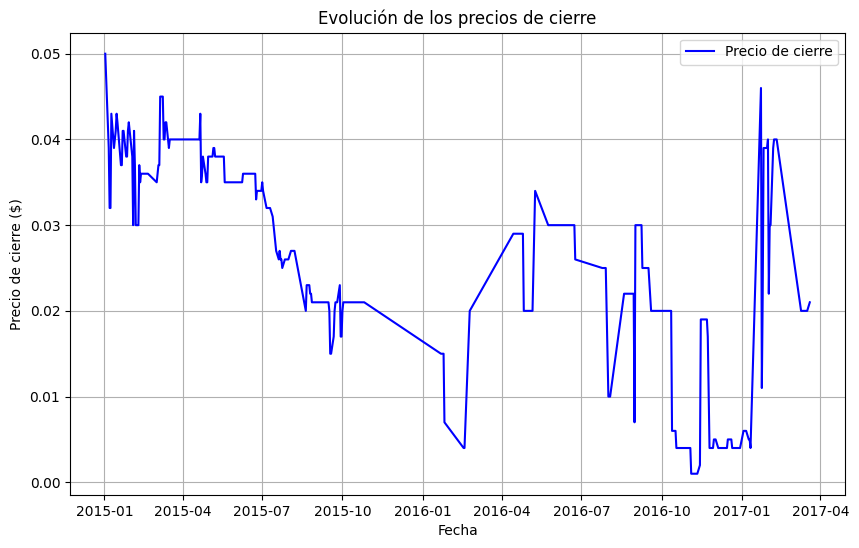

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Descargamos los datos de Walmart
ticker = "WTC"
df = yf.download(ticker,start="2015-01-01",end="2025-01-01")

print(df.head())


plt.figure(figsize=(10,6))

plt.plot(df.index,df['Close'],label='Precio de cierre',color='blue')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre ($)')
plt.title('Evolución de los precios de cierre')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df

Price,Close,High,Low,Open,Volume
Ticker,WTC,WTC,WTC,WTC,WTC
Date,,,,,
2015-01-02,0.050,0.050,0.050,0.050,0
2015-01-05,0.042,0.042,0.042,0.042,0
2015-01-06,0.039,0.039,0.039,0.039,0
2015-01-07,0.032,0.032,0.032,0.032,0
2015-01-08,0.032,0.032,0.032,0.032,0
...,...,...,...,...,...
2017-03-14,0.020,0.020,0.020,0.020,0
2017-03-15,0.020,0.020,0.020,0.020,0


In [3]:
# Calcular los retornos diarios
df['Daily Return'] = df['Close'].pct_change()

# Calcular la volatilidad (desviación estándar de los retornos)
volatility = df['Daily Return'].std()

print(f"📊 Volatilidad diaria de Walmart: {volatility:.4f} ({volatility*100:.2f}%)")

📊 Volatilidad diaria de Walmart: 0.7727 (77.27%)


Vamos a utilizar Arima. Este metodo sirve para realizar modelos estadísticos para poder "predecir" el futuro precio de Walmart en este ejemplo



In [5]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.6 MB/s eta 0:00:00


In [6]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [8]:
#Vamos a seleccionar la columna de Close y lo vamos a convertir en índice de tiempo
df = df[['Close']]
df.index = pd.to_datetime(df.index)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

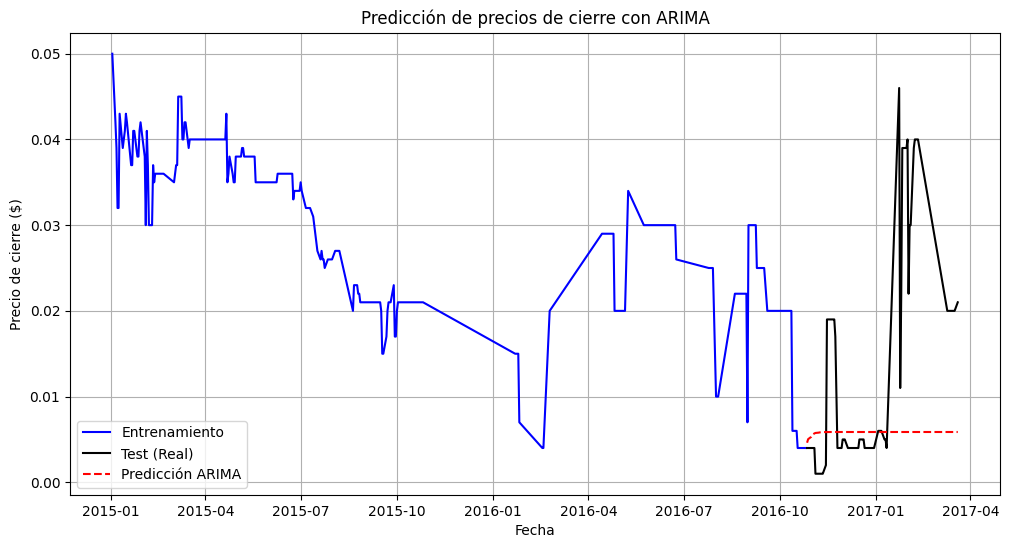

In [10]:
#Ahora lo que debemos hacer es separar una parte de los datos como entrenamiento
# y otros datos como test

#El 0.8 representa el 80% de entrenamiento. EL 20% restante sería el test_data
train_size = int(len(df) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]

#Realizamos el ajuste de arima (P=1,D=1,E=1, la formula original)
model = auto_arima(train_data,seasonal=True,stepwise=True)

#Realizamos las predicciones

arima_model = ARIMA(train_data,order=model.order)
#Con el método fit() hacemos que entrene el modelo
arima_model_fit = arima_model.fit()
#Repite el entramiento por la longitud de test_data
forecast = arima_model_fit.forecast(steps=len(test_data))

#Visualizamos

plt.figure(figsize=(12,6))
plt.plot(train_data.index,train_data['Close'],label='Entrenamiento',color='blue')
plt.plot(test_data.index,test_data['Close'],label='Test (Real)',color='black')
plt.plot(test_data.index,forecast,label='Predicción ARIMA',color='red',linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre ($)')
plt.title('Predicción de precios de cierre con ARIMA')
plt.legend()
plt.grid(True)



In [11]:
#Ahora vamos a evaluar ARIMA

from sklearn.metrics import mean_squared_error,mean_absolute_error

#Calculamos RMSE Y MAE

rmse = np.sqrt(mean_squared_error(test_data['Close'],forecast))
mae = mean_absolute_error(test_data['Close'],forecast)

print('Evaluación del modelo ARIMA')
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


Evaluación del modelo ARIMA
RMSE: 0.01
MAE: 0.01


In [12]:
#Ahora vamos a realizar RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['MA7'] = df['Close'].rolling(window=7).mean() #Media móvil de 7 días
df['MA30'] = df['Close'].rolling(window=30).mean() #Media móvil de 30 días
df['Daily_Return'] = df['Close'].pct_change() #Retornos diarios

#Eliminamos los valores nulos
df.dropna(inplace=True)

#Definimos la variable predictoras

X = df[['Year','Month','Day','MA7','MA30','Daily_Return']]
y = df['Close']

#Dividimos los datos en entrenamiento y test
# El 0.2 representa siempre el 20% de test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [14]:
#Creación y entrenamiento de Random Forest

rf = RandomForestRegressor(n_estimators=100,random_state=42)
rf.fit(X_train,y_train)

#Realizamos las predicciones

y_pred = rf.predict(X_test)

#Evaluación de modelo

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test,y_pred)

print(f"📊 Evaluación RandomForest:")
print(f"🔹 RMSE: {rmse:.2f}")
print(f"🔹 MAE: {mae:.2f}")


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


📊 Evaluación RandomForest:
🔹 RMSE: 0.01
🔹 MAE: 0.00


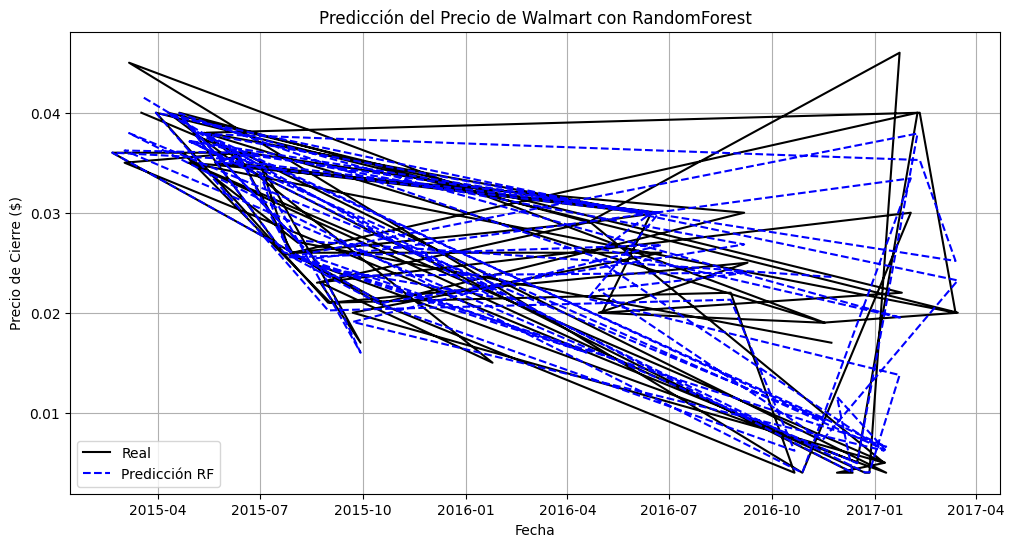

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Real', color='black')
plt.plot(y_test.index, y_pred, label='Predicción RF', color='blue', linestyle='dashed')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.title('Predicción del Precio de Walmart con RandomForest')
plt.legend()
plt.grid(True)
plt.show()
